In [2]:
# Load useful library kl

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb ,rgb2luv, luv2rgb
from matplotlib import cm
from sklearn.cluster import MeanShift, estimate_bandwidth
import cv2

# Usefull functions
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ int(h), int(s), int(v), :]
    return Iview/255

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

# HSV1

In [3]:
def quantize(v,K):
    return (np.where(v==1, K-1, np.floor(v*K)))


In [4]:
def quantizeImage(I, nH, nS, nV):
    Iq = np.zeros(I.shape).astype(int)
    Iq[:,:,0] = quantize(I[:,:,0], nH)

    Hist = np.zeros((nH, nS, nV))

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            Hist[Iq[i,j,0], Iq[i,j,1], Iq[i,j,2]] += 1
            
    return Iq,Hist

In [5]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)

In [6]:
w,h=400,400
def test_exo_1(I,nH,nS,nV):
    I_hsv=rgb2hsv(I)
    
    Iq,HistoIq=quantizeImage(I_hsv,nH,nS,nV)
    pal1, pal2 = setColors(nH, nS, nV)
   

    Iq_RGB=viewQuantizedImage(Iq,pal2)
    
    histo=normalize(HistoIq.flatten())

    fig = plt.figure(figsize=(w/60,h/60), layout="constrained")
    spec = fig.add_gridspec(6, 6)

    ax0 = fig.add_subplot(spec[0:3, :3])
    ax0.imshow(I)
    ax0.set_title("original")

    ax1 = fig.add_subplot(spec[0:3, 3:])
    ax1.imshow(Iq_RGB)
    ax1.set_title("Quantized")

    ax2 = fig.add_subplot(spec[4:, :])
    ax2.hist(histo,bins=256)
    ax2.set_title("Histogram")

    K = 6

    idx_most_prevalent = (-histo).argsort()[:K]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

    idx = np.argsort(histo)
    idx = idx[::-1]
    

    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal1[idx[i], 0]
        Ia[0,0,1] = pal1[idx[i], 1]
        Ia[0,0,2] = pal1[idx[i], 2]
        ax_tmp = fig.add_subplot(spec[3, i])
        ax_tmp.axis('off')
        ax_tmp.imshow(Ia)


In [7]:
maison=np.array(Image.open("maison.jpeg"))


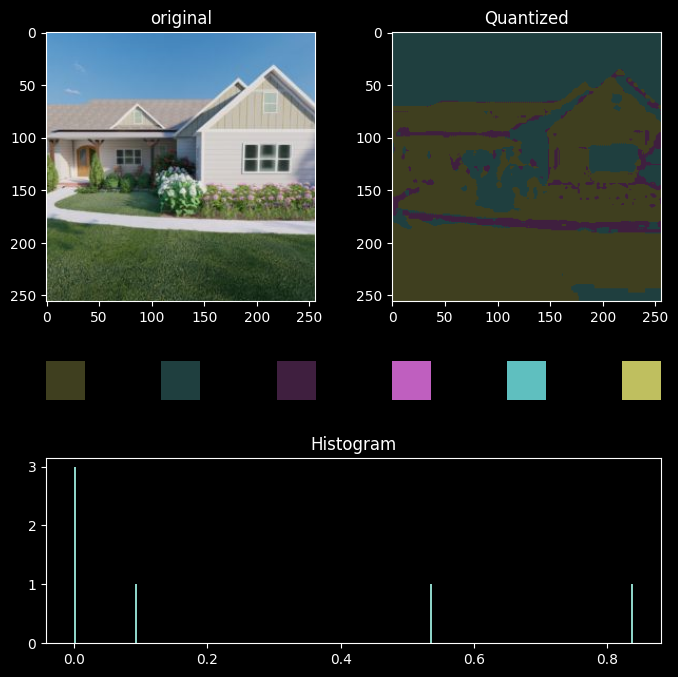

In [8]:
test_exo_1(maison,3,1,2)


Les paramètres nH, nS et nV de choisir avec quels paramètres on va segmenter les zones de l'image.

- H : la teinte des régions
- S : la saturation
- V : la brillance

La valeur qu'on donne à ces paramètres permet d'avoir une segmentation plus "fine" en ajustant le poids des composantes citées au dessus, cependant le nombre de régions totales valant (nH * nS * nV ) il ne faut pas prende des paramètres trop élevés au risque d'avoir une segmentation trop fine.

In [9]:
def similarityMatrix(listHisto):
    S=np.zeros((1040,1040))
    

In [37]:
a=np.array([[1,2],[2,3],[3,4]])
b=a.copy()

tmp_a=np.tile(a,(1,3)).reshape(3,3,2)

print(np.vstack((a,a,a)))

[[1 2]
 [2 3]
 [3 4]
 [1 2]
 [2 3]
 [3 4]
 [1 2]
 [2 3]
 [3 4]]


# Segmentation using Mean Shift algorithm

In [5]:
def visualisation_meanshift(I):
    fig = plt.figure(figsize=plt.figaspect(0.25))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(I)
    ax.set_title("original")

    tI=rgb2luv(I)
    print(tI.shape)

    X=tI[:,:,0].flatten()
    Y=tI[:,:,1].flatten()

    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(X,Y,s=1)
    ax.set_xlabel("L*")
    ax.set_ylabel("u*")
    ax.set_title("L* vs u*")

    plt.show()

    

In [13]:
hand=np.array(Image.open("hand.png"))[:,:,:3]

In [14]:
visualisation_meanshift(hand)

NameError: name 'visualisation_meanshift' is not defined

In [15]:
def Ke(x):
    #epanachikov
    if x>1:
        return 0
    else:
        return 1-x

def kn(x):
    #truncated normal
    return np.exp(-0.5*np.linalg.norm(x,2)**2)



In [16]:
#p=3 for luv

epsilon = 1e-4
distancemax=1e-1

def distance(x,y):
    return np.linalg.norm(x-y,2)

def meanshift(I,h1,h2,nb_iter):
    tI=rgb2luv(I)
    div=np.array([h1,h1,h2,h2,h2])

    tmp_res=np.zeros(I.shape)

    for u in range(45,46):
        for v in range(45,46):
            tmp_y=0
            y=np.array(([u,v,tI[u,v,0],tI[u,v,1],tI[u,v,2]]))
            somme_haut=[0,0,0,0,0]
            somme_bas=0

            for i in range(0,nb_iter):

                if i>10 and distance(y,tmp_y)<epsilon:
                    break
                
                for x_tmp in range(0,I.shape[0]):
                    for y_tmp in range(0,I.shape[1]):

                        tmp_p=np.array(([x_tmp,y_tmp,tI[x_tmp,y_tmp,0],tI[x_tmp,y_tmp,1],tI[x_tmp,y_tmp,2]]))

                        if distance(y,tmp_p)<distancemax:
                            print(x_tmp," .  ",y_tmp," .  ",y)
                        
                            tmp_p_g=np.linalg.norm((y-tmp_p)/div,2)**2
                            tmp_g=Ke(tmp_p_g)
                            somme_haut+=tmp_g*tmp_p
                            somme_bas+=tmp_g
                            y=(somme_haut/somme_bas)
            
            tmp_res[u,v]=y[2:]
    print(tmp_res)
    print("\n\n\n")
    print(tmp_res.shape)
                

                        

                


In [17]:
meanshift(hand,8,8,20)

45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]
45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]
45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]
45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]
45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]
45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]
45  .   45  .   [45.         45.         36.17632291  8.09383531 17.62129626]


KeyboardInterrupt: 

# Bilateral Filter

In [10]:
def imagePad(I,t) :
    nb = int((t - 1) / 2.0)
    mat1 = np.hstack((np.ones((I.shape[0], nb,3)), I, np.ones((I.shape[0], nb,3))))
    mat2 = np.vstack((np.ones((nb, mat1.shape[1],3)), mat1, np.ones((nb, mat1.shape[1],3))))
    return mat2

In [32]:
def u_gaussian(x,sigma):
    return np.exp(-0.5*x/sigma**2)


def gammaCorrection(I,g):
    """ Array * float -> Array """
    return (255*np.power(I/255,g)).astype(np.uint8)

def BilateralFilter(I,fsize,sig1,sig2):
    res=np.zeros(I.shape)
    transfo_I=rgb2luv(I)
    tmp_I=imagePad(transfo_I,fsize)
    padding= int((fsize - 1) / 2.0)

    mat_s= np.zeros((fsize,fsize,1))

    for i in range(-padding,padding+1):
        for j in range(-padding,padding+1):
            mat_s[i+padding,j+padding]=u_gaussian(np.sqrt((i)**2+(j)**2),sig2)

    mat_s=np.square(mat_s)


    for u in range(padding,I.shape[0]+padding):
        for v in range(padding,I.shape[1]+padding):

            fenetre=tmp_I[u-padding:u+padding+1,v-padding:v+padding+1,:]
            
            somme=1e-5
            somme_w=1e-5

            tmp_r=u_gaussian( np.linalg.norm(fenetre-tmp_I[u,v],2,axis=2)**2,sig1 )
            tmp_r=np.reshape(tmp_r,(fsize,fsize,1))
            
            tmp_w=tmp_r*mat_s

            
            fenetre=fenetre*tmp_w

            
            res[u-padding,v-padding]=np.sum(fenetre*tmp_r*mat_s,axis=(0,1))/np.sum(tmp_w)
            
            

    
    return (luv2rgb(res)*255).astype(np.uint8)

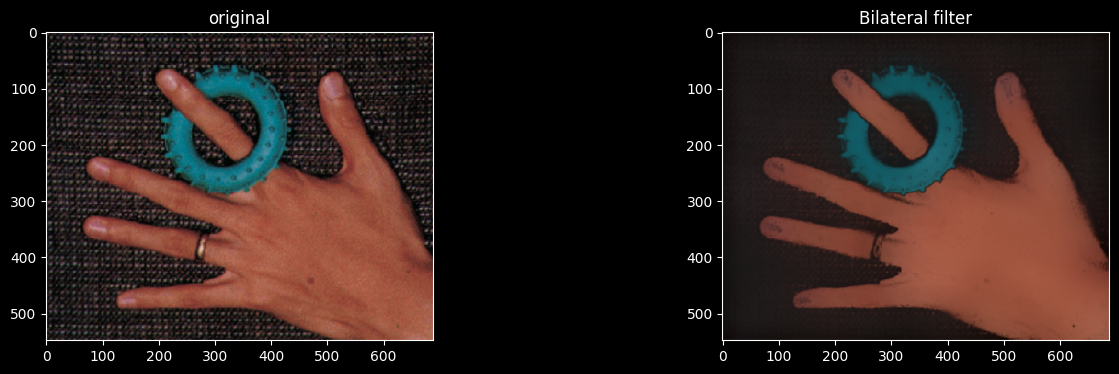

In [37]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(hand)
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow((BilateralFilter(hand,71,30,600.)))
ax.set_title("Bilateral filter")

plt.show()

In [188]:
display_gif("B_house.gif")

In [87]:
def test_segmentation(I,fsize,sig1,sig2):
    
    tmp_img=BilateralFilter(I,fsize,sig1,sig2)
    res_filt_img=tmp_img.copy()
    originShape = I.shape
    flatImg=np.reshape(tmp_img, [-1, 3])


    # Estimate bandwidth for meanshift algorithm    
    bandwidth = estimate_bandwidth(flatImg, quantile=0.1, n_samples=100)    
    ms = MeanShift(bandwidth = bandwidth, bin_seeding=True,min_bin_freq=1000)

    # Performing meanshift on flatImg    
    ms.fit(flatImg)

    # (r,g,b) vectors corresponding to the different clusters after meanshift    
    labels=ms.labels_

    # Remaining colors after meanshift    
    cluster_centers = ms.cluster_centers_    


    segmentedImg = (cluster_centers[np.reshape(labels, originShape[:2])]).astype(np.uint8)
    return segmentedImg,res_filt_img


def dessine_bordures(I,I_seg,seuil):
    res=I.copy()
    for u in range(1,I.shape[0]-1):
        for v in range(1,I.shape[1]-1):
            if np.linalg.norm(I_seg[u,v]-I_seg[u-1,v],2)>seuil or np.linalg.norm(I_seg[u,v]-I_seg[u+1,v],2)>seuil or np.linalg.norm(I_seg[u,v]-I_seg[u,v-1],2)>seuil or np.linalg.norm(I_seg[u,v]-I_seg[u,v+1],2)>seuil:
                res[u,v]=np.array([255,255,255])
                res[u-1,v]=np.array([255,255,255])
                res[u+1,v]=np.array([255,255,255])
                res[u,v+1]=np.array([255,255,255])
                res[u,v-1]=np.array([255,255,255])
    return res

In [93]:
def segmentation(I,fsize=31,sig1=300,sig2=30.):
    fig = plt.figure(figsize=plt.figaspect(0.25))

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(I)
    ax.set_title("original")

    image_seg,img_filt=test_segmentation(I,fsize,sig1,sig2)

    transfo_I=rgb2luv(image_seg.astype(np.uint8))

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(image_seg)
    ax.set_title("detected regions")

    

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(dessine_bordures(I,image_seg,100))
    
    ax.set_title("Segmentation with Bilateral filter")

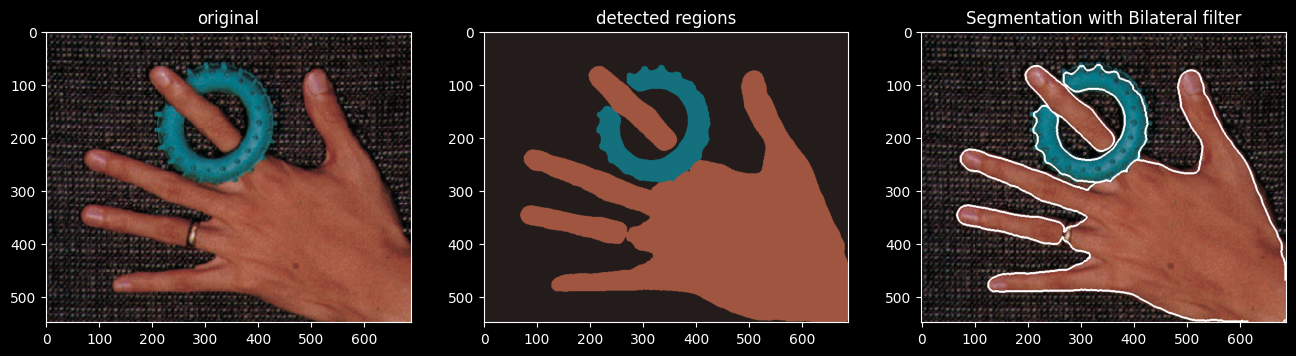

In [94]:
segmentation(hand,fsize=17,sig1=70,sig2=600.)

In [134]:
house=np.array(Image.open("house.tiff"))

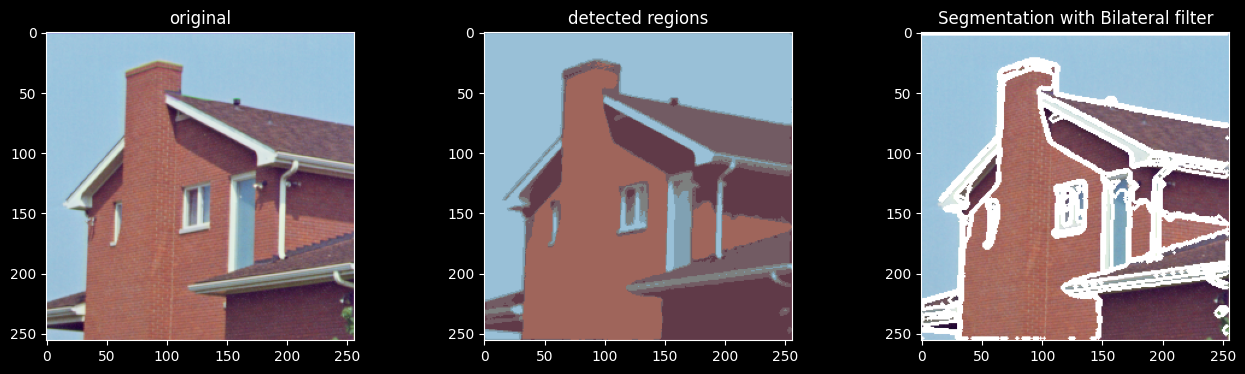

In [155]:
segmentation(house,fsize=5,sig1=41,sig2=10.)

# Gif

In [189]:
nb_images=64

w,h=400,400

#gaussian_arg=9
sig1_arg=np.linspace(1,100,nb_images)
sig2_arg=np.linspace(0.1,10,nb_images)

tmp=hand

for i in range(0,nb_images,1):
    fig = plt.figure(figsize=plt.figaspect(0.25))
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow((BilateralFilter(tmp,17,sig1_arg[i],10.)))
    ax.set_title("sig1:"+str(np.round(sig1_arg[i],2))+" sig2:"+str(10.))

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(tmp)
    ax.set_title("original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.abs(tmp-(BilateralFilter(tmp,17,10.,sig2_arg[i]))))
    ax.set_title("sig1:"+str(10.)+" sig2:"+str(np.round(sig2_arg[i],2)))
    ax.set_xlabel("Difference between original and filtered image")

    

    plt.savefig('gen_gif_'+str(i)+'.png')
    plt.close()

In [190]:
nom_gif="B_hand.gif"


with imageio.get_writer(nom_gif, mode='I') as writer:
    for i in range(1,nb_images,1):
        image = imageio.v2.imread('gen_gif_'+str(i)+'.png')
        writer.append_data(image)

for i in range(1,nb_images,1):
    os.remove('gen_gif_'+str(i)+'.png') 

In [191]:
display_gif(nom_gif)